#  User traffic through our life insurance product funnel

## Importing main packages and libraries

In [41]:
%load_ext autoreload
%autoreload 2

import os
import sys

current_dir = os.getcwd()
Modules_dir = os.path.abspath(os.path.join(current_dir,'Modules'))
sys.path.append(Modules_dir)

from packages_library import *
from functions_library import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [3]:
path_to_data = os.path.abspath('Input_data')
file1 = '/funnel_path.csv'
file2 = '/users.csv'
df_funnel = pd.read_csv(path_to_data+file1)
df_users = pd.read_csv(path_to_data+file2)

In [4]:
df_funnel.head()

,user_id,funnel_steps
0,1001,collect_contact_info
1,1001,started_navigator
2,1002,application_submit
3,1002,collect_contact_info
4,1002,phone_connect


In [5]:
df_users.head()

,user_id,age,device,income,num_conditions,premium,marketing_channels
0,1001,56,desktop,157490,5,2490.123774,instagram
1,1002,34,desktop,138171,3,1906.228442,paid_search_nb
2,1003,32,desktop,94274,2,1515.217172,paid_search_nb
3,1004,32,desktop,160480,4,2263.763328,tv
4,1005,33,desktop,141943,3,1624.410806,podcast


## Cleaning data

In [6]:
df_funnel_clean = Clean_raw_data(df_funnel)

No missing values on dataset
There aren't duplicated rows

Nº rows 
before cleaning: 27629    after cleaning:27629 



In [7]:
df_users_clean = Clean_raw_data(df_users)

No missing values on dataset
There aren't duplicated rows

Nº rows 
before cleaning: 10000    after cleaning:10000 



## Inspection of funnel step dataset

    1- user_id: the key that identifies the user
    2- funnel_steps: represents the steps each user got to in the product funnel

In [8]:
funnel_steps = df_funnel_clean['funnel_steps'].unique()
print('There are {} funnel steps'.format(len(funnel_steps)))
for i,step in enumerate(funnel_steps):
    print(i+1, step)

There are 6 funnel steps
1 collect_contact_info
2 started_navigator
3 application_submit
4 phone_connect
5 sign_and_exam
6 viewed_quotes


In [9]:
n_users = len(df_funnel_clean['user_id'].unique())
print('There are {} users on the data set'.format(n_users))

There are 10000 users on the data set


### How many customers completed each stage of the process?

In [64]:
df_step_process = df_funnel_clean.groupby(['funnel_steps']).count().sort_values(by=('user_id'),
                                         ascending=False).rename(columns={'user_id':'n_users'})

df_step_process['% users'] = 100*df_step_process['n_users']/n_users

fig = px.funnel(df_step_process, 
                x = df_step_process['% users'], 
                y = df_step_process.index,
                title='Funnel steps plot')
fig.show()

The process to get a life insurance goes through 6 stages starting with the started_navigator where everybody enters the process and then in every next step the amount of clientes is decreasing up to the final step which represent the signing of the life insurance document. Currently the conversion rate, considering the whole process is 7.84% which represent 784 clientes out of 10000.

## Inspection of users dataset
    1- user_id: the key that identifies the user. 
    2- age: how old the customer applying for life insurance is. 
    3- device: indicates the type of device a customer came in on. This allows you to differentiate between mobile and desktop and also what kind of mobile device (ios vs android)
    4- income: annual income as provided by the customer. 
    5- num_conditions: how many health conditions the customer has. 
    6- premium: the annual price for the lowest policy from the quotes provided to customers. This is what the customer will pay a year. 
    7- marketing_channels - the marketing channel the customer came from. 


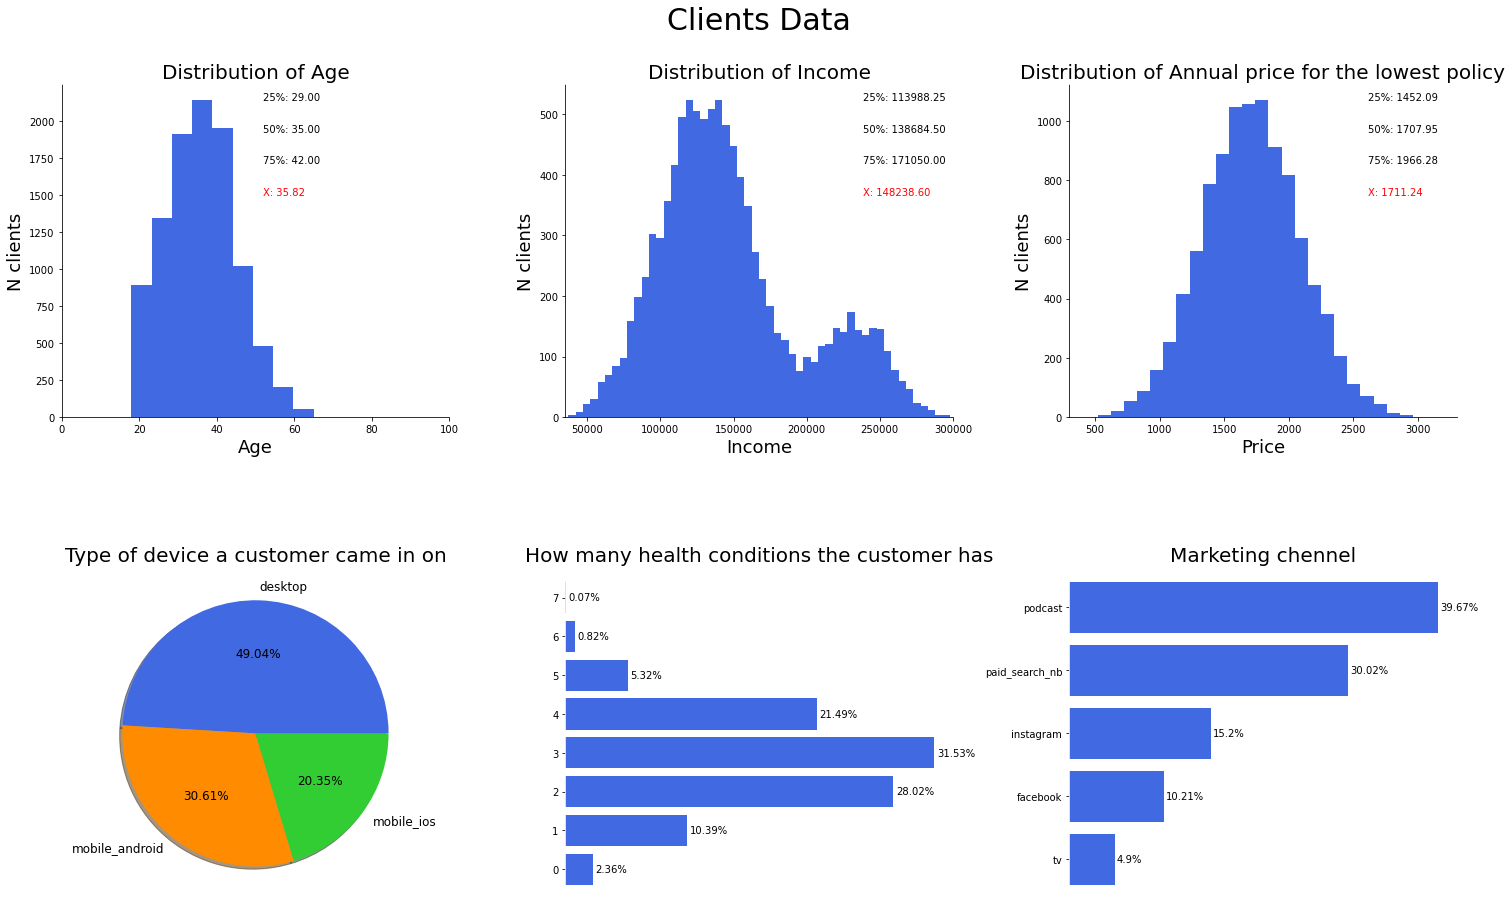

In [11]:
age_plot = [df_users_clean.age, 5, 0, 100, "Distribution of Age", 'Age', 'N clients', False, True]
income_plot = [df_users_clean.income, 5000, 35000, 300000, "Distribution of Income", 'Income', 'N clients', False, True]
premium_plot = [df_users_clean.premium, 100, 300, 3300, 'Distribution of Annual price for the lowest policy', 'Price','N clients', False, True]
device_plot = [df_users_clean.device, 'Type of device a customer came in on']
n_conditions_plot = [df_users_clean['num_conditions'], 'How many health conditions the customer has']
marketing_channels_plot = [df_users_clean.marketing_channels, 'Marketing chennel']

Plot_users_data(age_plot, income_plot, premium_plot, device_plot, n_conditions_plot, marketing_channels_plot)

## Conversion rate through the funnel considering different by marketing channels and contact devices

In [12]:
df = pd.merge(df_funnel, df_users, on='user_id', how='inner')

In [13]:
df.head()

,user_id,funnel_steps,age,device,income,num_conditions,premium,marketing_channels
0,1001,collect_contact_info,56,desktop,157490,5,2490.123774,instagram
1,1001,started_navigator,56,desktop,157490,5,2490.123774,instagram
2,1002,application_submit,34,desktop,138171,3,1906.228442,paid_search_nb
3,1002,collect_contact_info,34,desktop,138171,3,1906.228442,paid_search_nb
4,1002,phone_connect,34,desktop,138171,3,1906.228442,paid_search_nb


In [14]:
# Create dataframe to store the convertion rate by different Marketing Channel
df_cr = pd.DataFrame()

# run the loop over every marketing channel
for channel in ['podcast','paid_search_nb','instagram','facebook','tv']:
    df_channel = df[df['marketing_channels']==channel].groupby(['funnel_steps'])[['user_id']].count().sort_values(by=('user_id'), ascending=False).rename(columns={'user_id':'n_users'})
    df_channel['%_group'] = 100*df_channel['n_users']/df_channel['n_users'][0]
    df_channel['%_group'] = df_channel['%_group'].round(2)
    df_mark_ch = pd.merge(df_channel, df_step_process, left_index=True, right_index=True)
    df_mark_ch['marketing_channel'] = channel
    df_cr = pd.concat([df_cr, df_mark_ch], axis=0)

df_cr['% users'] = 100*df_cr['n_users_x']/df_cr['n_users_y']
df_cr['% users'] = df_cr['% users'].round(2)
fig = px.funnel(df_cr, 
                x = '%_group', 
                y = df_cr.index, 
                color='marketing_channel',
                title='Effectiveness rate by marketing channel')
fig.show()

Considering the 5 marketing channels where the customer came from I found different convertion rates (CR) for each one of them, where from top to bottom we have the following results:
    
    - tv             CR = 11.43%
    - paid search nb CR = 10.09%
    - facebook       CR = 9.5%
    - instagram      CR = 6.97%
    - podcast        CR = 5.6%

Even though podcast channel is the most used one, the conversion rate for it is the lowest. On the other hand the less used marketing channel (tv) is the most sucssesful one with the highest CR.

In [65]:
# Create dataframe to store the convertion rate by different contact device
df_cd = pd.DataFrame()

for device in ['desktop','mobile_ios','mobile_android']:
    df_device = df[df['device']==device].groupby(['funnel_steps'])[['user_id']].count().sort_values(by=('user_id'),
                                                            ascending=False).rename(columns={'user_id':'n_users'})
    df_device['%_group'] = 100*df_device['n_users']/df_device['n_users'][0]
    df_device['%_group'] = df_device['%_group'].round(2)
    df_device_ch = pd.merge(df_device, df_step_process, left_index=True, right_index=True)
    df_device_ch['device_type'] = device
    df_cd = pd.concat([df_cd, df_device_ch], axis=0)

df_cd['% users'] = 100*df_cd['n_users_x']/df_cd['n_users_y'] 
fig = px.funnel(df_cd, 
                x = '%_group', 
                y = df_cd.index, 
                color='device_type',
                title='Effectiveness rate by device type')
fig.show()

Considering the 3 contact devices that customers used I found different convertion rates (CR) for each one of them, where from top to bottom we have the following results:
    
    - mobile ios       CR = 14.89%
    - desktop          CR = 8.14%
    - mobile android   CR = 2.68%

The same behaviour we see in the marketing channels occurs here. The less used device (mobile ios) is the one with the highest CR, almost doubling the next device.

## Conversion rate at segment level

Giving that we are working with numerical continuous features it is convenient to use a statistical tests that can help to select those features that have the strongest relationship with the output variable. For that propose I will use a scikit-learn package. I will also include into this analysis the categorical variables we analyzed above, however, because categorical features are not supported by this package I will convert those features to numerical one assigning them integer numbers, one for each category. 

In [29]:
df_funnel_clean['funnel_final_step_number'] = df_funnel_clean['funnel_steps']
df_funnel_clean['funnel_final_step_number'].replace(['started_navigator',
                                                     'collect_contact_info',
                                                     'viewed_quotes',
                                                     'application_submit',
                                                     'phone_connect',
                                                     'sign_and_exam'],[1, 2, 3, 4, 5, 6], inplace=True)

In [30]:
df_users_clean['device_number'] = df_users_clean['device']
df_users_clean['device_number'].replace(['desktop',
                                         'mobile_android',
                                         'mobile_ios'],[1, 2, 3], inplace=True)


In [31]:
df_users_clean['marketing_channels_number'] = df_users_clean['marketing_channels']
df_users_clean['marketing_channels_number'].replace(['podcast',
                                                     'paid_search_nb',
                                                     'facebook',
                                                     'instagram',
                                                     'tv'],[1, 2, 3, 4 ,5], inplace=True)

In [34]:
## We select the final step where the client end up the process
df_funnel_final = df_funnel_clean.groupby(['user_id'])[['funnel_final_step_number']].max().reset_index()

In [66]:
df_final = pd.merge(df_funnel_final, df_users_clean, on=['user_id'], how='inner')
df_final = df_final[['age',
                     'income',
                     'num_conditions',
                     'premium',
                     'device_number',
                     'marketing_channels_number',
                     'funnel_final_step_number']]

In [38]:
df_final.head()

,age,income,num_conditions,premium,device_number,marketing_channels_number,funnel_final_step_number
0,56,157490,5,2490.123774,1,4,2
1,34,138171,3,1906.228442,1,2,6
2,32,94274,2,1515.217172,1,2,1
3,32,160480,4,2263.763328,1,5,1
4,33,141943,3,1624.410806,1,1,1


First we will check which of the features are more important providing the highest information to the predict the funnel_steps

In [39]:
#independent columns
X = df_final[['age','income','num_conditions','premium','device_number','marketing_channels_number']]
#output column 
y = df_final['funnel_final_step_number']    

In [45]:
## Ranking of the most important features 
bestfeatures = SelectKBest(score_func=chi2, k=6)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(6,'Score'))

                    Features         Score
1                     income  3.848862e+06
3                    premium  2.902756e+04
0                        age  1.772373e+03
2             num_conditions  2.832447e+02
4              device_number  5.163145e+01
5  marketing_channels_number  4.961300e+01


Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards the prediction of the funnel_steps. 
We also can use another tool to confirm this feature ranking.

[0.20564057 0.32815707 0.06387272 0.32677074 0.01202581 0.06353309]


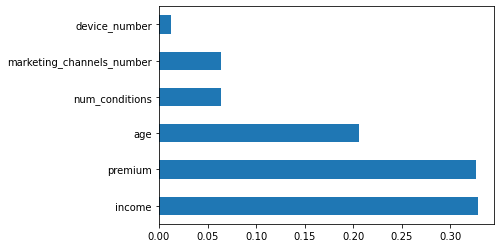

In [46]:
## Feature Importance
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

Both of the above tests show us the same result where 'income', 'premium' and 'age' are the 3 most important features of the dataset.

Finally we can check whether the features are correlated to each other or not. For that propouse we can use the correlation function available in python. Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable)

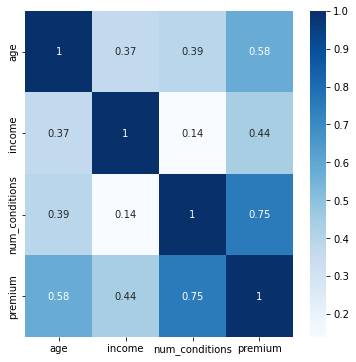

In [73]:
corrmat = X[['age','income','num_conditions','premium']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(6,6))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="Blues")

From here we can see that the highest correlated features are these pairs:
    
    a) premium - num_conditions: corr = 75%
    b) premium - age:            corr = 58%

The final step is to cross check that level of correlation among the features. For that purpose we can plot 2D and 1D histograms between the continuous features. A 2D histogram will tell us the common ground between 2 continuous features where the region with darker blue color are more correlated than the lighter blue regions. Moreover, the projection toward each axis of the 2D histogram will generate a 1D histogram where we can see the frequency of clients distributed over each corresponding feature. 


For practical purposes of finding the areas that contain the largest number of clients that reached the final stage of the process (sign and exam), the blue quadrants in the 2D histogram shows us the regions that meet that criteria highlighted with a dark blue color. In addition, at the center of each quadrant we write the number of clients that shared those features. I also shown the distribution of clients on each 1D histogram for every different step of the process starting with the first step represented with the grren histogram and ending with the sigh and exam step represented with the blue histogram.

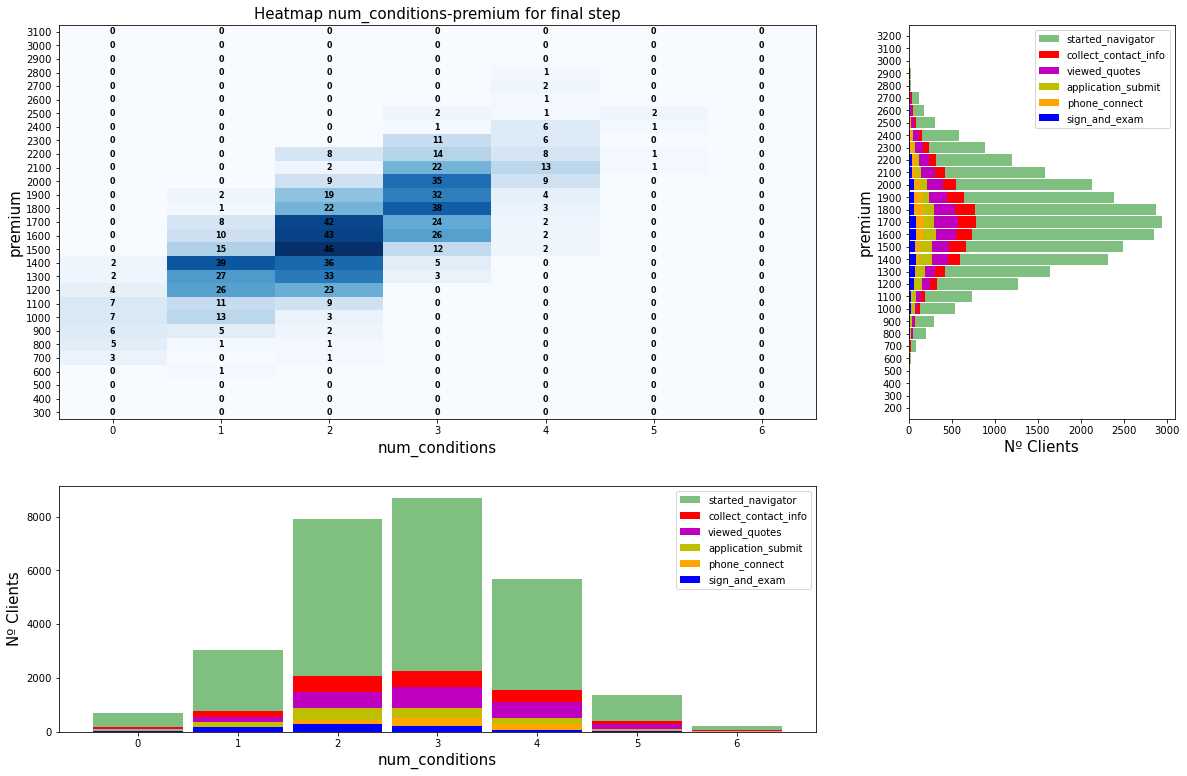

In [55]:
Heatmap_2D(df, 'num_conditions', 0, 8, 1, 'premium', 300, 3300, 100, text_on=True)

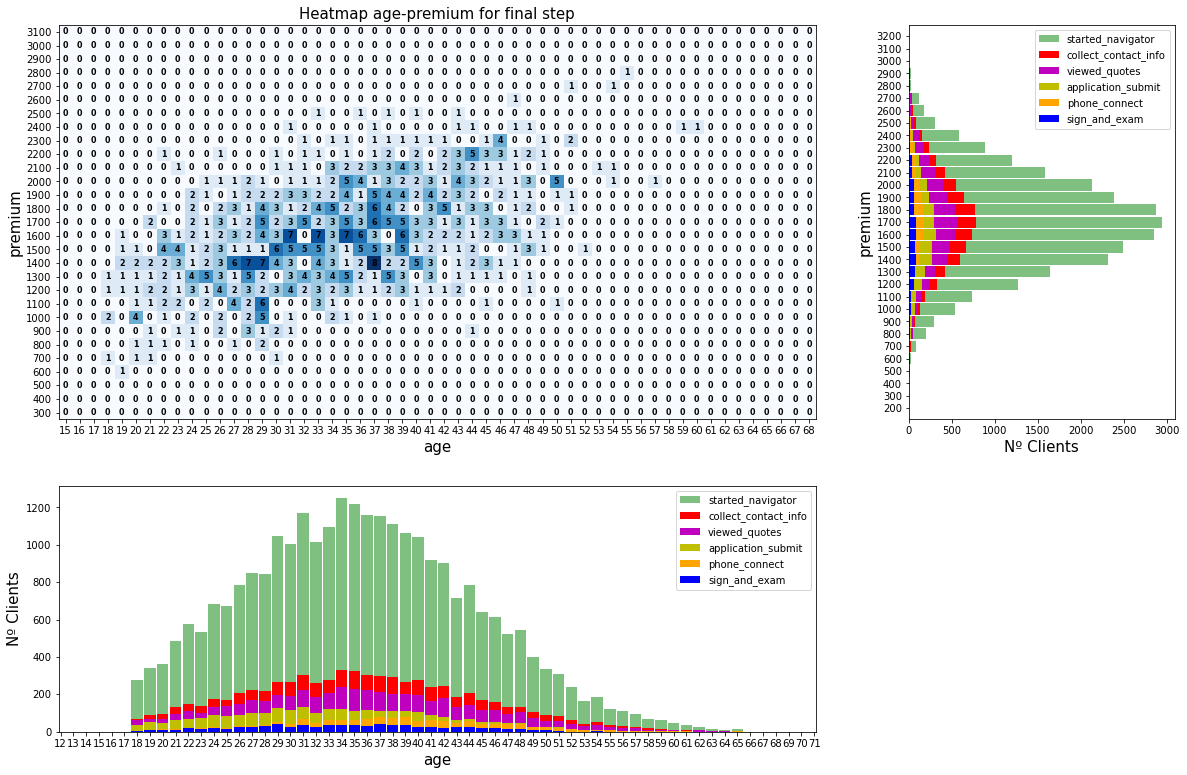

In [61]:
Heatmap_2D(df, 'age', 15, 70, 1, 'premium', 300, 3300, 100, text_on=True)

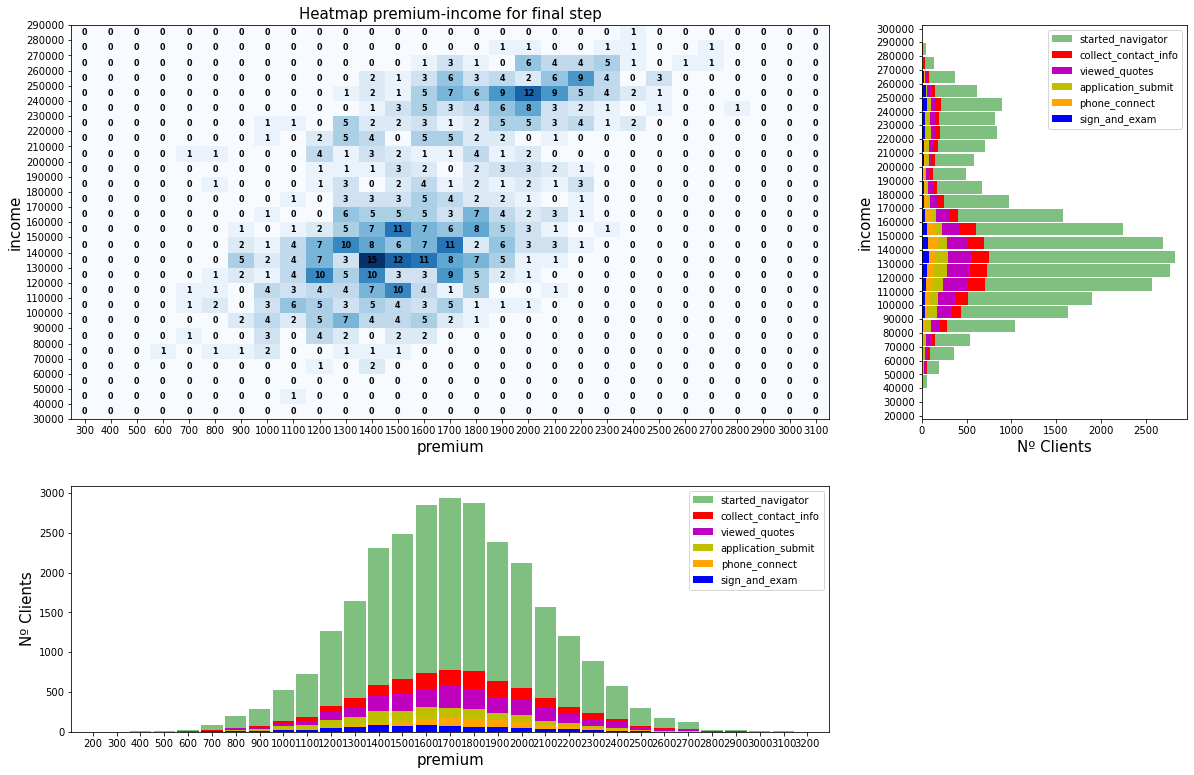

In [59]:
Heatmap_2D(df, 'premium', 300, 3300, 100, 'income', 35000, 300000, 10000, text_on=True)

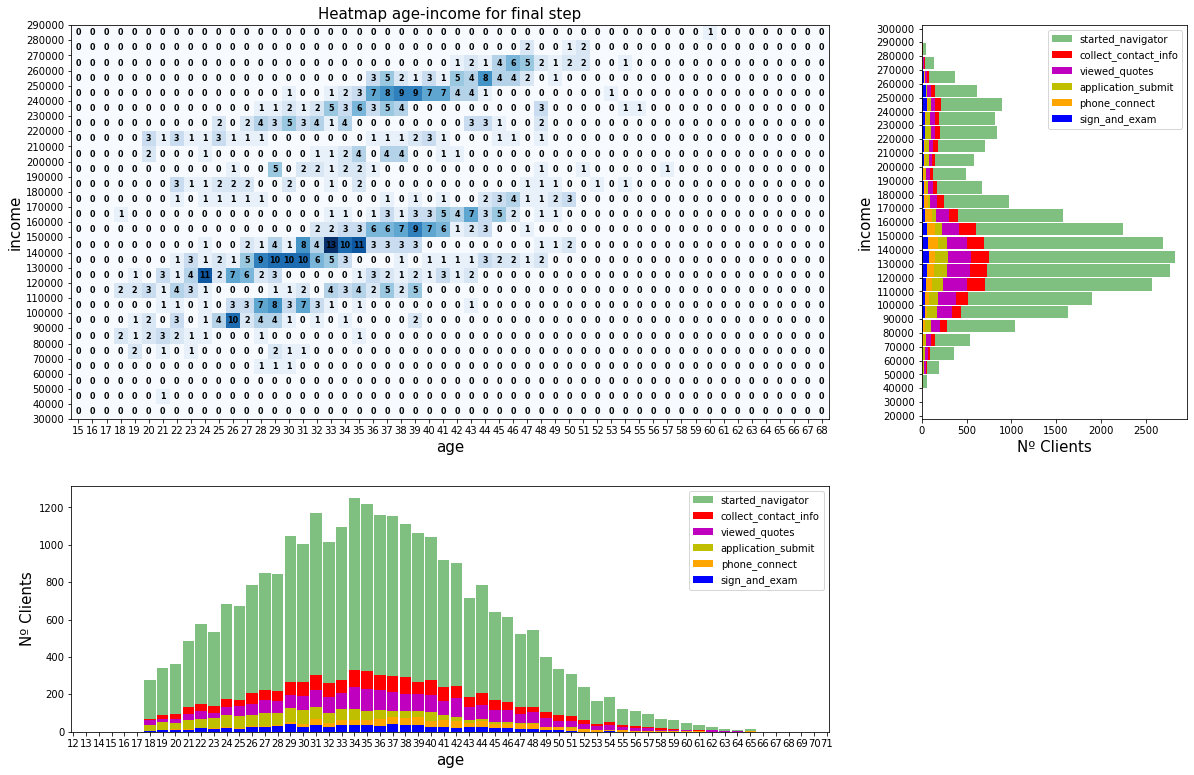

In [60]:
Heatmap_2D(df, 'age', 15, 70, 1, 'income', 35000, 300000, 10000, text_on=True)